# Script for replicating the finger print generation from the Bandana paper

In [1]:
%matplotlib inline

import math
import numpy as np
import matplotlib

from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema, resample
from madgwick.madgwickahrs import MadgwickAHRS
from madgwick.madgwickahrs import Quaternion
from trans import rotation_matrix
from quat import Quat
import csv

/Users/wxie/git/bandana/trans.py:1899: UserWarning: failed to import module _transformations
  warnings.warn("failed to import module %s" % name)


In [2]:
# Transformation matrices
def R_z(x):
    return np.array([
        [np.cos(x), -np.sin(x), 0],
        [np.sin(x), np.cos(x), 0],
        [0, 0, 1]
    ])

def R_y(x):
    return np.array([
        [np.cos(x), 0, np.sin(x)],
        [0, 1, 0],
        [-np.sin(x), 0, np.cos(x)]
    ])

def R_x(x):
    return np.array([
        [1, 0, 0],
        [0, np.cos(x), -np.sin(x)],
        [0, np.sin(x), np.cos(x)]
    ])

def R_rad(r, e):
    assert(len(e) == 3)
    return np.array([
        [np.cos(r) + e[0]**2*(1-np.cos(r)), e[0]*e[1]*(1-np.cos(r))-e[2]*np.sin(r), e[0]*e[2]*(1-np.cos(r))+e[1]*np.sin(r)],
        [e[1]*e[0]*(1-np.cos(r))+e[2]*np.sin(r), np.cos(r)+e[1]**2*(1-np.cos(r)), e[1]*e[2]*(1-np.cos(r)-e[0]*np.sin(r))],
        [e[2]*e[0]*(1-np.cos(r))-e[1]*np.sin(r), e[2]*e[1]*(1-np.cos(r))+e[0]*np.sin(r), np.cos(r)+e[2]**2*(1-np.cos(r))]
    ])

def plot_spectrum(y,f_s):
    # Number of sample points
    N = len(y)
    # sample spacing
    T = 1.0 / f_s
    x = np.linspace(0.0, N*T, N)
    yf = sp_fft(y)
    freq_vec = np.linspace(0.0, 1.0/(2.0*T), N/2)
    Y_f=2.0/N * np.abs(yf[0:N/2])
    plt.plot(freq_vec, Y_f)
    return Y_f,freq_vec

# Chunk Z and A equally
def chunks(Z, A, n):
    assert(len(Z) == len(A))
    chunk_size = len(Z) // n
    # print(chunk_size)
    for i in range(0, len(Z), chunk_size):
        yield Z[i:i+chunk_size], A[i:i+chunk_size]

def auto_corr(z, k):
    sigma = np.var(z)
    n = len(z)
    z1 = z[:-k]
    z2 = z[k:]
    assert(len(z1) == len(z2))
    a = np.vdot(z1, z2) / ((n - k) * pow(sigma, 2))

    return a

In [3]:

def main():
    tau = 10                    # Parameter for deviation for each gait cycle
    rho = 40                    # Number of samples resampled in each gait cycle
    b = 4                       # Number of bits for each gait cycle

    time_range = 300                # Time duration for graph display

    input_file = "short_walk.csv" # At 50 Hz
    skip_seconds = 1
    sample_rate = 100

    # Each entry is (x, y, z) tuple
    accel = []
    rot   = []
    magn  = []
    timestamp = []

    with open(input_file, 'r') as csvfile:
        data_reader = csv.reader(csvfile)

        row_count = 0
        for row in data_reader:
            # Skip the headers
            if row_count < 5:
                row_count += 1
                continue

            if row[0]:
                # Convert all data to floats
                # My data
                # accel.append((float(row[7]), float(row[8]), float(row[9]))) # Gravity only
                accel.append((float(row[7])+float(row[10]), float(row[8])+float(row[11]), float(row[9])+float(row[12])))
                rot.append((float(row[4]), float(row[5]), float(row[6])))
                magn.append((float(row[13]), float(row[14]), float(row[15])))

                # Test data
                # accel.append((float(row[1]), float(row[2]), float(row[3]))) # Gravity only
                timestamp.append(float(row[0]))

    # Normalize the timestamps
    time_offset = min(timestamp)
    timestamp = [ (time - time_offset) for time in timestamp ] # To seconds

    print("sample_rate:")
    print(sample_rate)

    # Resampling and correct timstamp sampling drift
    print("signal duration:")
    print(max(timestamp))
    t = list(np.arange(0, max(timestamp), 1.0/sample_rate))
    accel_x, accel_y, accel_z = list(zip(*accel))
    accel_x_new = np.interp(t, timestamp, accel_x)
    accel_y_new = np.interp(t, timestamp, accel_y)
    accel_z_new = np.interp(t, timestamp, accel_z)

    accel_resampled = list(zip(accel_x_new, accel_y_new, accel_z_new))

    plt.subplot(311)
    plt.plot(accel_resampled)
    plt.subplot(312)
    accel_mag = [ np.linalg.norm(xyz) for xyz in accel_resampled ]
    plt.plot(accel_mag)
    plt.subplot(313)
    # Windowed magnitude
    accel_mag_avg = []
    for i in range(len(accel_mag)):
        if i > len(accel_mag) - sample_rate:
            break
        accel_mag_avg.append(sum(accel_mag[i:(i+sample_rate)]) / sample_rate)

    plt.plot(accel_mag_avg)
    plt.show()

    # Find sample rate (timestamp in us)
    # sample_rate = int(np.floor(1000000 / (timestamp[1] - timestamp[0])))

    # Madgwick normalization
    # accel = [(1,0,0) for i in range(len(accel))]
    # rot   = [(0,0,0) for i in range(len(accel))]
    e = []
    rad = []
    roll = []
    pitch = []
    yaw = []
    transforms = []
    mw = MadgwickAHRS(sampleperiod=1/sample_rate, quaternion=Quaternion(1, 0, 0, 0), beta=0.02)
    for rot_tup, accel_tup, magn_tup in zip(rot, accel, magn):
        mw.update_imu(rot_tup, accel_tup)
        # mw.update(rot_tup, accel_tup, magn_tup)
        roll_i, pitch_i, yaw_i = mw.quaternion.to_euler123()
        rad_i, x_i, y_i, z_i = mw.quaternion.to_angle_axis()
        quat = Quat(list(mw.quaternion.q))
        transforms.append(quat.transform)

        e.append((x_i, y_i, z_i))
        rad.append(rad_i)
        roll.append(roll_i)
        pitch.append(pitch_i)
        yaw.append(yaw_i)
        # print("{}\t{}\t{}".format(roll_i, pitch_i, yaw_i))

    # for accel_i, r, p, y in zip(accel, roll, pitch, yaw):
    accel_rect = []
    z = []
    for accel_i, rad_i, e_i, trans in zip(accel, rad, e, transforms):
        accel_i_vec = (np.array(accel_i))
        # print("orig: {}".format(accel_i_vec))
        # accel_i_rect = R_x(r).dot(R_y(p)).dot(R_z(y)).dot(accel_i_vec)
        # accel_i_rect = np.linalg.inv(R_x(r).dot(R_y(p)).dot(R_z(y))).dot(accel_i_vec)
        # accel_i_rect = R_z(y).dot(R_y(p)).dot(R_x(r)).dot(accel_i_vec)
        # accel_i_rect = np.linalg.inv(R_z(y).dot(R_y(p)).dot(R_x(r))).dot(accel_i_vec)

        R = rotation_matrix(rad_i, e_i)[:3, :3]
        _R = R_rad(rad_i, e_i)

        # print(R)
        # print(_R)

        accel_i_rect = np.linalg.inv(R).dot(accel_i_vec)
        # accel_i_rect = R.dot(accel_i_vec)
        accel_i_rect = np.linalg.inv(trans).dot(accel_i_vec)
        # accel_i_rect = trans.dot(accel_i_vec)

        # accel_i_rect = np.linalg.inv(R_rad(rad_i, e_i)).dot(accel_i_vec)
        # accel_i_rect = R_rad(rad_i, e_i).dot(accel_i_vec)

        # print("rect: {}".format(accel_i_rect))
        accel_rect.append(accel_i_rect)

    # temp = list(zip(roll, pitch, yaw))
    # plt.plot(temp)
    # plt.show()

    # plt.subplot(211)
    # plt.plot(accel[:1000])

    # plt.subplot(212)
    # plt.plot(accel_rect[:1000])
    # plt.show()

    # Pick final channel as input
    # z = [ accel_i[1] for accel_i in accel ] # Pick Y axis as input
    # z = [ accel_i[2] for accel_i in accel_rect ]

    z = list(accel_y_new)

    # Manually filter out the beginning non-step movements
    # z = z[400:1100]
    z = z[400:1200]

    # Bandpass filter
    cutoff = [0.5, 10]                 # Cutoff frequency in Hz
    Wn = [cutoff[0]/(sample_rate/2), cutoff[1]/(sample_rate/2)]
    filter_b, filter_a = signal.cheby2(7, 40, Wn[1], btype='lowpass')
    filter_b, filter_a = signal.cheby2(5, 40, Wn, btype='bandpass')
    # filter_b, filter_a = signal.butter(5, Wn, btype='band', analog=False)

    z_filtered = signal.filtfilt(filter_b, filter_a, z)

    # plt.plot(list(zip(z, z_filtered)))
    # plt.show()

    z_orig = z
    z = z_filtered

    plt.plot(z)
    plt.show()

    ####################################################################################################
    # a is indexed by different values of k
    a = [ auto_corr(z, k) for k in range(1, len(z) - 1) ]

    zeta = argrelextrema(np.array(a), np.greater)

    # output for zeta is a 1D tuple, de-tuple zeta
    assert(len(zeta) == 1)
    zeta = zeta[0]

    print("zeta:")
    print(zeta)

    # Reject outliers to denoise
    m = 2                       # Reject m std outliers
    zeta_filtered = zeta[abs(zeta - np.mean(zeta)) < m * np.std(zeta)]
    delta_mean = int(np.ceil(np.sum(np.subtract(zeta_filtered[1:], zeta_filtered[:-1])) / (len(zeta) - 1)))

    print("difference zeta")
    print(np.subtract(zeta[1:], zeta[:-1]))
    print("delta_mean:")
    print(delta_mean)

    mu = []

    seen = set()
    for zeta_i in zeta:
        # Index window for z to find each local minum
        z_min_window_indices = range(max(zeta_i - tau, 0), min(zeta_i + delta_mean + tau, len(z) - 1))
        z_min_window = [ z[i] for i in z_min_window_indices ]

        mu_i = z_min_window_indices[np.argmin(z_min_window)] # get back the indices of z
        if mu_i not in seen:
            mu.append(mu_i)
            seen.add(mu_i)

    print("mu (len={}):".format(len(mu)))
    print(mu)

    mu_mean = int(np.ceil(np.sum(np.subtract(mu[1:], mu[:-1])) / (len(mu) - 1)))
    print("mu_mean:")
    print(mu_mean)

    # Resegment the data
    Z = []                      # list of lists
    oddindices = list(range(1, len(mu) - 1, 2))
    for i in oddindices:
        Z_i = z[mu[i-1] : mu[i+1]]
        # Resample
        Z_i_resampled = resample(Z_i, rho)
        assert(len(Z_i_resampled) == rho)
        Z.append(Z_i_resampled)

    # BANDANA
    # Quantization
    # Average of each sample over all gait cycles
    A = [ sum(z_i_list) / len(z_i_list) for z_i_list in zip(*Z) ]
    assert(len(A) == rho)

    # Extract fingerprint
    delta = []
    for Z_i in Z:
        for Z_chunk, A_chunk in chunks(Z_i, A, b):
            delta_i = sum(A_chunk) - sum(Z_chunk)
            delta.append(delta_i)

    assert(len(delta) == len(Z) * b)

    f = [ 1 if delta_i > 0 else 0 for delta_i in delta ]

    assert(len(delta) == len(f))

    print("delta:")
    # print(delta)
    print("Finger print:")
    print(f)

    # Sort f based on reliability (descending order from most reliable)
    delta_ordered, f_ordered = zip(*[ p for p in sorted(zip(delta, f), key=lambda pair: abs(pair[0]), reverse=True) ])

    # print(delta_ordered)
    # print(f_ordered)

    # Plot!
    plt.plot(z_orig)
    plt.plot(z)
    even_indices= list(range(0, len(mu) - 1, 2))
    for index in even_indices:
        plt.axvline(x=mu[index], color='r')

    print("{} gait cycles".format(len(Z)))
    plt.show()

    # plt.subplot(211)
    # plt.plot(range(time_range), z[:time_range])

    # for mu_i in mu:
    #     if mu_i < time_range:
    #         plt.axvline(x=mu_i, color='r')

    # plt.subplot(212)
    # temp = [ z_i for Z_i in Z for z_i in Z_i ]
    # time_range_resampled = int(np.ceil(time_range * rho / sample_rate / 2))
    # plt.plot(range(time_range_resampled), temp[:time_range_resampled])

    # total = 0
    # for Z_i in Z:
    #     plt.axvline(x=total, color='r')
    #     total += len(Z_i)
    #     if total > time_range_resampled:
    #         break

    # plt.savefig('cycle_plot.png')

    print("Done")


sample_rate:
100
signal duration:
47.42837595939636


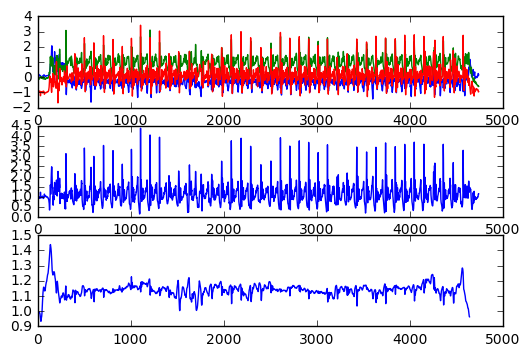

zeta:
[ 18  50 100 117 150 201 219 254 302 343 358 402 445 459 504 542 561 583
 603 621 635 655 675 704 722 731 780 794]
difference zeta
[32 50 17 33 51 18 35 48 41 15 44 43 14 45 38 19 22 20 18 14 20 20 29 18  9
 49 14]
delta_mean:
29
mu (len=25):
[16, 88, 93, 115, 188, 195, 217, 292, 299, 341, 396, 401, 442, 497, 500, 542, 599, 600, 622, 625, 693, 696, 719, 721, 785]
mu_mean:
33
delta:
Finger print:
[0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0]
12 gait cycles


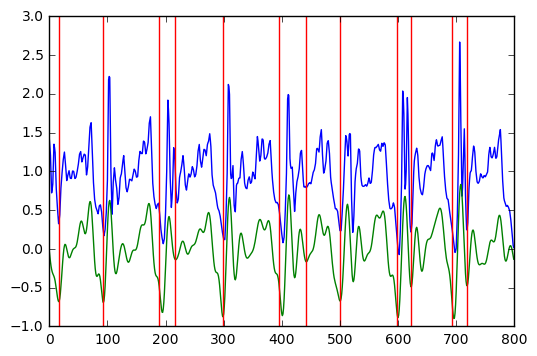

Done


In [4]:

if __name__ == '__main__':
    main()
